# Debugging VQE first to see where to integrate CNOTTing

In [11]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import re
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Now some of my own code for mediating twirling + noise amp for parameterized circuits

In [12]:

def addCXerror(circ, c): 
    '''
    Input: Scale factor and circuit 
    Output: Circuit with scaled noise
    '''
#     print(circ)
    newqasm_str=""
    qs=circ.qasm()
#     print('starting stringification now')
#     print(qs.splitlines())
#     print('ending stringification now')
#     print('Cant even understand its own stuff')
#     circy=QuantumCircuit().from_qasm_str(qs)
#     print('I am wrong')
    qregname=circ.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith('cx'):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1

            newqasm_str+=line+"\n"

            ## increase the error rate of a cx gate
            for i in range(1,c):
                newqasm_str+="""barrier q[0],q[1];\n"""
                newqasm_str+="cx"+" "+qregname+"["+str(control_ind)+"],"+qregname+"["+str(target_ind)+"];\n"
                newqasm_str+="""barrier q[0],q[1];\n"""
        else:
            newqasm_str+=line+"\n"
#     print('Here is the circuit string:')
#     print(newqasm_str)
    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
#     print('Adding CX errors done')
    return circo

In [22]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def ParamStringToCirc(string, parameters):
    """
    Input: A qasm string with some param and a Parameter[] object
    Assumption: Lots ..main one is that param gate is the u3 one
    
    Expected Input: 
    u3(0,0,-2.0*θ[0]) q[3];
    
    Why Needed? Because Qiskit cannot understand symbols like theta
    
    Output: Corresponding param circuit and the qubit it acts on 
    """
    #print('Param Circ Converted Called')
    
    #break up the string 
    strings = string.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    #print(strings)
    
    #variables from the string 
    param = parameters[int(strings[4][2])]
    n_qubit = int(strings[5][3])
    angle1 = int(strings[1])  #assume no pi
    angle2 = int(strings[2])  #assume no pi
    factor = float(strings[3])  #assume an int 
    
    #making the circuit 
    circ = QuantumCircuit(1)
    circ.u3(angle1, angle2, factor*param, 0)
    #print(circ)
    
    return circ, n_qubit

In [34]:
ansatz_view = []

def AnsatzCNOTAmplifyer(string, parameters, c): 
    """
    Input: A qasm circuit string and  a list of parameters, noise amplification constant c
    Output: Applying  noise amplification to the circuit
    """
   # print("Asatz Converter Called")
    global ansatz_view 
    ansatz_view.append(string)
    
    #some auxiliary variables 
    line_num = 0; 
    paramAtStart = False; 
    openingline1 = ""
    openingline2 = ""
    openingline3 = ""
    circuit_strs = []
    current_str = ""
    param_circs = []
    param_qubits = []
    
    #dividing 
    for line in iter(string.splitlines()): 
        line_num+=1
        
        #opening block 
        if line_num == 1: 
            openingline1 = line 
        elif line_num == 2: 
            openingline2 = line
        elif line_num == 3:
            openingline3 = line
        #otherwise
        else: 
            
            if not ("θ" in line): 
                current_str = current_str +'\n' + line
            #otherwise deal with case where encounter param
            else: 
                #end circuit string
                circuit_strs.append(current_str)
                current_str = ''
                #make param gate 
                param_circ, param_qubit = ParamStringToCirc(line, parameters)
                param_circs.append(param_circ)
                param_qubits.append(param_qubit)
                #update param
                if (line_num == 3): 
                    paramAtStart= True
            
                    
    #Check if all sub circuits have been added
    if(current_str !=''): 
        circuit_strs.append(current_str)
        
    #now adding the opening block and converting all to circuits 
    sub_circs = []
    opening_block = openingline1 +'\n'+openingline2 + '\n' + openingline3
    for string in circuit_strs:
        string = opening_block + '\n' + string
        #print(string)
        circ = QuantumCircuit().from_qasm_str(string)
        sub_circs.append(circ)
    
    # ampifying noise in each sub circuit
    new_sub_circs = []
    for circ in sub_circs: 
        circ = addCXerror(circ, c)
        new_sub_circs.append(circ)
    sub_circs = new_sub_circs
        
    
    #now recombining subcircuits and param circuits
    ind_param = 0
    ind_sub = 0
    qubits = [i for i in range(sub_circs[0].num_qubits)]
    
    circuit = QuantumCircuit(sub_circs[0].num_qubits)
    if(paramAtStart): 
        circuit.append(param_circs[0], [param_qubits[0]])
        ind_param+=1
    while ind_sub < len(sub_circs): 
        
        circuit.append(sub_circs[ind_sub], qubits)
        ind_sub+=1
        
        if(ind_param < len(param_circs)):
            circuit.append(param_circs[ind_param], [param_qubits[ind_param]])
            ind_param += 1
    #print('the circuit is ')
    #print(circuit.decompose().decompose())
    return circuit

In [35]:
# #Two_error_map is needed so amplifier can increase error appropriately
# machine = provider.get_backend('ibmqx2')
# two_error_map =  get_cx_error_map(machine)

## Some Helper Libraries

In [36]:
import warnings
from abc import ABC, abstractmethod
from typing import List, Optional, Union, Dict

import numpy as np
from qiskit.aqua.algorithms import AlgorithmResult
from qiskit.aqua.operators import OperatorBase, LegacyBaseOperator


class MinimumEigensolver(ABC):
    """The Minimum Eigensolver Interface.
    Algorithms that can compute a minimum eigenvalue for an operator
    may implement this interface to allow different algorithms to be
    used interchangeably.
    """

    @abstractmethod
    def compute_minimum_eigenvalue(
            self,
            operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
            aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                        LegacyBaseOperator]]]] = None
    ) -> 'MinimumEigensolverResult':
        """
        Computes minimum eigenvalue. Operator and aux_operators can be supplied here and
        if not None will override any already set into algorithm so it can be reused with
        different operators. While an operator is required by algorithms, aux_operators
        are optional. To 'remove' a previous aux_operators array use an empty list here.
        Args:
            operator: If not None replaces operator in algorithm
            aux_operators:  If not None replaces aux_operators in algorithm
        Returns:
            MinimumEigensolverResult
        """
        if operator is not None:
            self.operator = operator  # type: ignore
        if aux_operators is not None:
            self.aux_operators = aux_operators if aux_operators else None  # type: ignore
        return MinimumEigensolverResult()

    def supports_aux_operators(self) -> bool:
        """Whether computing the expectation value of auxiliary operators is supported.
        If the minimum eigensolver computes an eigenstate of the main operator then it
        can compute the expectation value of the aux_operators for that state. Otherwise
        they will be ignored.
        Returns:
            True if aux_operator expectations can be evaluated, False otherwise
        """
        return False

    @property  # type: ignore
    @abstractmethod
    def operator(self) -> Optional[Union[OperatorBase, LegacyBaseOperator]]:
        """Return the operator."""
        raise NotImplementedError

    @operator.setter  # type: ignore
    @abstractmethod
    def operator(self, operator: Union[OperatorBase, LegacyBaseOperator]) -> None:
        """Set the operator."""
        raise NotImplementedError

    @property  # type: ignore
    @abstractmethod
    def aux_operators(self) -> Optional[List[Optional[OperatorBase]]]:
        """Returns the auxiliary operators."""
        raise NotImplementedError

    @aux_operators.setter  # type: ignore
    @abstractmethod
    def aux_operators(self,
                      aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                                  LegacyBaseOperator]]]]) -> None:
        """Set the auxiliary operators."""
        raise NotImplementedError


class MinimumEigensolverResult(AlgorithmResult):
    """ Minimum Eigensolver Result."""

    @property
    def eigenvalue(self) -> Union[None, complex]:
        """ returns eigen value """
        return self.get('eigenvalue')

    @eigenvalue.setter
    def eigenvalue(self, value: complex) -> None:
        """ set eigen value """
        self.data['eigenvalue'] = value

    @property
    def eigenstate(self) -> Union[None, np.ndarray]:
        """ return eigen state """
        return self.get('eigenstate')

    @eigenstate.setter
    def eigenstate(self, value: np.ndarray) -> None:
        """ set eigen state """
        self.data['eigenstate'] = value

    @property
    def aux_operator_eigenvalues(self) -> Union[None, np.ndarray]:
        """ return aux operator eigen values """
        return self.get('aux_operator_eigenvalues')

    @aux_operator_eigenvalues.setter
    def aux_operator_eigenvalues(self, value: np.ndarray) -> None:
        """ set aux operator eigen values """
        self.data['aux_operator_eigenvalues'] = value

    @staticmethod
    def from_dict(a_dict: Dict) -> 'MinimumEigensolverResult':
        """ create new object from a dictionary """
        return MinimumEigensolverResult(a_dict)

    def __getitem__(self, key: object) -> object:
        if key == 'energy':
            warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else value.real
        elif key == 'energies':
            warnings.warn('energies deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else [value.real]
        elif key == 'eigvals':
            warnings.warn('eigvals deprecated, use eigenvalue property.', DeprecationWarning)
            value = super().__getitem__('eigenvalue')
            return None if value is None else [value]
        elif key == 'eigvecs':
            warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
            value = super().__getitem__('eigenstate')
            return None if value is None else [value]
        elif key == 'aux_ops':
            warnings.warn('aux_ops deprecated, use aux_operator_eigenvalues property.',
                          DeprecationWarning)
            value = super().__getitem__('aux_operator_eigenvalues')
            return None if value is None else [value]

        return super().__getitem__(key)

In [37]:
"""The Variational Quantum Algorithm Base Class.
This class can be used an interface for working with Variation Quantum Algorithms, such as VQE,
QAOA, or QSVM, and also provides helper utilities for implementing new variational algorithms.
Writing a new variational algorithm is a simple as extending this class, implementing a cost
function for the new algorithm to pass to the optimizer, and running :meth:`find_minimum` method
of this class to carry out the optimization. Alternatively, all of the functions below can be
overridden to opt-out of this infrastructure but still meet the interface requirements.
"""

from typing import Optional, Callable, Union
import time
import logging
import warnings
from abc import abstractmethod
import numpy as np

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.providers import BaseBackend
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import AlgorithmResult, QuantumAlgorithm
from qiskit.aqua.components.optimizers import Optimizer, SLSQP
from qiskit.aqua.components.variational_forms import VariationalForm

logger = logging.getLogger(__name__)

# pylint: disable=invalid-name


class VQAlgorithm(QuantumAlgorithm):
    """The Variational Quantum Algorithm Base Class."""

    def __init__(self,
                 var_form: Union[QuantumCircuit, VariationalForm],
                 optimizer: Optimizer,
                 cost_fn: Optional[Callable] = None,
                 initial_point: Optional[np.ndarray] = None,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:
        """
        Args:
            var_form: An optional parameterized variational form (ansatz).
            optimizer: A classical optimizer.
            cost_fn: An optional cost function for optimizer. If not supplied here must be
                supplied on :meth:`find_minimum`.
            initial_point: An optional initial point (i.e. initial parameter values)
                for the optimizer.
            quantum_instance: Quantum Instance or Backend
        Raises:
             ValueError: for invalid input
        """
        super().__init__(quantum_instance)

        if optimizer is None:
            logger.info('No optimizer provided, setting it to SLSPQ.')
            optimizer = SLSQP()

        self._optimizer = optimizer
        self._cost_fn = cost_fn
        self._initial_point = initial_point
        self._var_form = var_form
        self._var_form_params = None
        if var_form is not None:
            self.var_form = var_form

        self._parameterized_circuits = None

    @property
    def var_form(self) -> Optional[Union[QuantumCircuit, VariationalForm]]:
        """ Returns variational form """
        return self._var_form

    @var_form.setter
    def var_form(self, var_form: Optional[Union[QuantumCircuit, VariationalForm]]):
        """ Sets variational form """
        if isinstance(var_form, QuantumCircuit):
            # store the parameters
            self._var_form_params = sorted(var_form.parameters, key=lambda p: p.name)
            self._var_form = var_form
        elif isinstance(var_form, VariationalForm):
            self._var_form_params = ParameterVector('θ', length=var_form.num_parameters)
            self._var_form = var_form
        elif var_form is None:
            self._var_form_params = None
            self._var_form = var_form
        else:
            raise ValueError('Unsupported type "{}" of var_form'.format(type(var_form)))

    @property
    def optimizer(self) -> Optional[Optimizer]:
        """ Returns optimizer """
        return self._optimizer

    @optimizer.setter
    def optimizer(self, optimizer: Optimizer):
        """ Sets optimizer """
        self._optimizer = optimizer

    @property
    def initial_point(self) -> Optional[np.ndarray]:
        """ Returns initial point """
        return self._initial_point

    @initial_point.setter
    def initial_point(self, initial_point: np.ndarray):
        """ Sets initial point """
        self._initial_point = initial_point

    def find_minimum(self,
                     initial_point: Optional[np.ndarray] = None,
                     var_form: Optional[Union[QuantumCircuit, VariationalForm]] = None,
                     cost_fn: Optional[Callable] = None,
                     optimizer: Optional[Optimizer] = None,
                     gradient_fn: Optional[Callable] = None) -> 'VQResult':
        """Optimize to find the minimum cost value.
        Args:
            initial_point: If not `None` will be used instead of any initial point supplied via
                constructor. If `None` and `None` was supplied to constructor then a random
                point will be used if the optimizer requires an initial point.
            var_form: If not `None` will be used instead of any variational form supplied via
                constructor.
            cost_fn: If not `None` will be used instead of any cost_fn supplied via
                constructor.
            optimizer: If not `None` will be used instead of any optimizer supplied via
                constructor.
            gradient_fn: Optional gradient function for optimizer
        Returns:
            dict: Optimized variational parameters, and corresponding minimum cost value.
        Raises:
            ValueError: invalid input
        """
        initial_point = initial_point if initial_point is not None else self.initial_point
        var_form = var_form if var_form is not None else self.var_form
        cost_fn = cost_fn if cost_fn is not None else self._cost_fn
        optimizer = optimizer if optimizer is not None else self.optimizer

        if var_form is None:
            raise ValueError('Variational form neither supplied to constructor nor find minimum.')
        if cost_fn is None:
            raise ValueError('Cost function neither supplied to constructor nor find minimum.')
        if optimizer is None:
            raise ValueError('Optimizer neither supplied to constructor nor find minimum.')

        nparms = var_form.num_parameters

        if hasattr(var_form, 'parameter_bounds') and var_form.parameter_bounds is not None:
            bounds = var_form.parameter_bounds
        else:
            bounds = [(None, None)] * nparms

        if initial_point is not None and len(initial_point) != nparms:
            raise ValueError(
                'Initial point size {} and parameter size {} mismatch'.format(
                    len(initial_point), nparms))
        if len(bounds) != nparms:
            raise ValueError('Variational form bounds size does not match parameter size')
        # If *any* value is *equal* in bounds array to None then the problem does *not* have bounds
        problem_has_bounds = not np.any(np.equal(bounds, None))
        # Check capabilities of the optimizer
        if problem_has_bounds:
            if not optimizer.is_bounds_supported:
                raise ValueError('Problem has bounds but optimizer does not support bounds')
        else:
            if optimizer.is_bounds_required:
                raise ValueError('Problem does not have bounds but optimizer requires bounds')
        if initial_point is not None:
            if not optimizer.is_initial_point_supported:
                raise ValueError('Optimizer does not support initial point')
        else:
            if optimizer.is_initial_point_required:
                if hasattr(var_form, 'preferred_init_points'):
                    # Note: default implementation returns None, hence check again after below
                    initial_point = var_form.preferred_init_points

                if initial_point is None:  # If still None use a random generated point
                    low = [(l if l is not None else -2 * np.pi) for (l, u) in bounds]
                    high = [(u if u is not None else 2 * np.pi) for (l, u) in bounds]
                    initial_point = self.random.uniform(low, high)

        #start = time.time()
        if not optimizer.is_gradient_supported:  # ignore the passed gradient function
            gradient_fn = None
        
        #debug 
#         print('Inside Base Algo find_minimum---------------------------------------')
#         print('Number of params is ' + str(nparms))
#         print('cost function is ')
#         print(cost_fn)
#         print('gradient function is ')
#         print(gradient_fn)

        logger.info('Starting optimizer.\nbounds=%s\ninitial point=%s', bounds, initial_point)
        opt_params, opt_val, num_optimizer_evals = optimizer.optimize(nparms,
                                                                      cost_fn,
                                                                      variable_bounds=bounds,
                                                                      initial_point=initial_point,
                                                                      gradient_function=gradient_fn)
        eval_time = 0

        vqresult = VQResult()
        vqresult.optimizer_evals = num_optimizer_evals
        vqresult.optimizer_time = eval_time
        vqresult.optimal_value = opt_val
        vqresult.optimal_point = opt_params
        vqresult.optimal_parameters = dict(zip(self._var_form_params, opt_params))
        
        result = {}
        
        result['optimizer_evals'] = num_optimizer_evals
        result['optimizer_time'] = eval_time
        result['optimal_value'] = opt_val
        result['optimal_point'] = opt_params
        result['optimal_parameters'] = dict(zip(self._var_form_params, opt_params))
#         print('Result is ')
#         print(result)

        return result, vqresult

    def get_prob_vector_for_params(self, construct_circuit_fn, params_s,
                                   quantum_instance, construct_circuit_args=None):
        """ Helper function to get probability vectors for a set of params """
        circuits = []
        for params in params_s:
            circuit = construct_circuit_fn(params, **construct_circuit_args)
            circuits.append(circuit)
        results = quantum_instance.execute(circuits)

        probs_s = []
        for circuit in circuits:
            if quantum_instance.is_statevector:
                sv = results.get_statevector(circuit)
                probs = np.real(sv * np.conj(sv))
                probs_s.append(probs)
            else:
                counts = results.get_counts(circuit)
                probs_s.append(self.get_probabilities_for_counts(counts))
        return np.array(probs_s)

    def get_probabilities_for_counts(self, counts):
        """ get probabilities for counts """
        shots = sum(counts.values())
        states = int(2 ** len(list(counts.keys())[0]))
        probs = np.zeros(states)
        for k, v in counts.items():
            probs[int(k, 2)] = v / shots
        return probs

    @abstractmethod
    def get_optimal_cost(self):
        """ get optimal cost """
        raise NotImplementedError()

    @abstractmethod
    def get_optimal_circuit(self):
        """ get optimal circuit """
        raise NotImplementedError()

    @abstractmethod
    def get_optimal_vector(self):
        """ get optimal vector """
        raise NotImplementedError()

    @property
    @abstractmethod
    def optimal_params(self):
        """ returns optimal parameters """
        raise NotImplementedError()

    def cleanup_parameterized_circuits(self):
        """ set parameterized circuits to None """
        self._parameterized_circuits = None


class VQResult(AlgorithmResult):
    """ Variation Quantum Algorithm Result."""

    @property
    def optimizer_evals(self) -> int:
        """ Returns number of optimizer evaluations """
        return self.get('optimizer_evals')

    @optimizer_evals.setter
    def optimizer_evals(self, value: int) -> None:
        """ Sets number of optimizer evaluations """
        self.data['optimizer_evals'] = value

    @property
    def optimizer_time(self) -> float:
        """ Returns time taken for optimization """
        return self.get('optimizer_time')

    @optimizer_time.setter
    def optimizer_time(self, value: float) -> None:
        """ Sets time taken for optimization  """
        self.data['optimizer_time'] = value

    @property
    def optimal_value(self) -> float:
        """ Returns optimal value """
        return self.get('optimal_value')

    @optimal_value.setter
    def optimal_value(self, value: int) -> None:
        """ Sets optimal value """
        self.data['optimal_value'] = value

    @property
    def optimal_point(self) -> np.ndarray:
        """ Returns optimal point """
        return self.get('optimal_point')

    @optimal_point.setter
    def optimal_point(self, value: np.ndarray) -> None:
        """ Sets optimal point """
        self.data['optimal_point'] = value

    @property
    def optimal_parameters(self) -> dict:
        """ Returns the optimal parameters in a dictionary """
        return self.get('optimal_parameters')

    @optimal_parameters.setter
    def optimal_parameters(self, value: dict) -> None:
        """ Sets optimal parameters """
        self.data['optimal_parameters'] = value

    def __getitem__(self, key: object) -> object:
        if key == 'num_optimizer_evals':
            return self.optimizer_evals()
        elif key == 'min_val':
            #print('I was here in get item of VQ result trynna get min_val')
            return self.optimal_cost()
        elif key == 'opt_params':
            return self.optimal_parameters()
        elif key == 'eval_time':
            warnings.warn('eval_time deprecated, use optimizer_time property.',
                          DeprecationWarning)
            return self.optimal_time()


## Now onto VQE

In [38]:
from typing import Optional, List, Callable, Union, Dict
import logging
import warnings
from time import time
import numpy as np

from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.providers import BaseBackend
from qiskit.aqua import QuantumInstance, AquaError
from qiskit.aqua.algorithms import QuantumAlgorithm
from qiskit.aqua.operators import (OperatorBase, ExpectationBase, ExpectationFactory, StateFn,
                                   CircuitStateFn, LegacyBaseOperator, ListOp, I, CircuitSampler)
from qiskit.aqua.components.optimizers import Optimizer, SLSQP
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.utils.validation import validate_min
#from ..vq_algorithm import VQAlgorithm, VQResult
#from .minimum_eigen_solver import MinimumEigensolver, MinimumEigensolverResult

logger = logging.getLogger(__name__)

# disable check for var_forms, optimizer setter because of pylint bug
# pylint: disable=no-member


class VQE_mod(VQAlgorithm, MinimumEigensolver):
    r"""The Variational Quantum Eigensolver algorithm.

    `VQE <https://arxiv.org/abs/1304.3061>`__ is a hybrid algorithm that uses a
    variational technique and interleaves quantum and classical computations in order to find
    the minimum eigenvalue of the Hamiltonian :math:`H` of a given system.

    An instance of VQE requires defining two algorithmic sub-components:
    a trial state (ansatz) from Aqua's :mod:`~qiskit.aqua.components.variational_forms`, and one
    of the classical :mod:`~qiskit.aqua.components.optimizers`. The ansatz is varied, via its set
    of parameters, by the optimizer, such that it works towards a state, as determined by the
    parameters applied to the variational form, that will result in the minimum expectation value
    being measured of the input operator (Hamiltonian).

    An optional array of parameter values, via the *initial_point*, may be provided as the
    starting point for the search of the minimum eigenvalue. This feature is particularly useful
    such as when there are reasons to believe that the solution point is close to a particular
    point.  As an example, when building the dissociation profile of a molecule,
    it is likely that using the previous computed optimal solution as the starting
    initial point for the next interatomic distance is going to reduce the number of iterations
    necessary for the variational algorithm to converge.  Aqua provides an
    `initial point tutorial <https://github.com/Qiskit/qiskit-tutorials-community/blob/master
    /chemistry/h2_vqe_initial_point.ipynb>`__ detailing this use case.

    The length of the *initial_point* list value must match the number of the parameters
    expected by the variational form being used. If the *initial_point* is left at the default
    of ``None``, then VQE will look to the variational form for a preferred value, based on its
    given initial state. If the variational form returns ``None``,
    then a random point will be generated within the parameter bounds set, as per above.
    If the variational form provides ``None`` as the lower bound, then VQE
    will default it to :math:`-2\pi`; similarly, if the variational form returns ``None``
    as the upper bound, the default value will be :math:`2\pi`.

    .. note::

        The VQE stores the parameters of ``var_form`` sorted by name to map the values
        provided by the optimizer to the circuit. This is done to ensure reproducible results,
        for example such that running the optimization twice with same random seeds yields the
        same result. Also, the ``optimal_point`` of the result object can be used as initial
        point of another VQE run by passing it as ``initial_point`` to the initializer.

    """

    def __init__(self,
                 operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
                 var_form: Optional[Union[QuantumCircuit, VariationalForm]] = None,
                 optimizer: Optional[Optimizer] = None,
                 initial_point: Optional[np.ndarray] = None,
                 expectation: Optional[ExpectationBase] = None,
                 include_custom: bool = False,
                 max_evals_grouped: int = 1,
                 aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                             LegacyBaseOperator]]]] = None,
                 callback: Optional[Callable[[int, np.ndarray, float, float], None]] = None,
                 scale = 1,
                 twirl_amp = False,
                 reps = 100,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:
        """

        Args:
        ----------------------------Edited
            scale: Noise amplification factor
            twirl_amp: Boolean to verify whether we are twirling and adding errors to VQE circuits
            reps: how many times should we twirl and calculate expec val (sampling value)
        ----------------------------Edited
            operator: Qubit operator of the Observable
            var_form: A parameterized circuit used as Ansatz for the wave function.
            optimizer: A classical optimizer.
            initial_point: An optional initial point (i.e. initial parameter values)
                for the optimizer. If ``None`` then VQE will look to the variational form for a
                preferred point and if not will simply compute a random one.
            expectation: The Expectation converter for taking the average value of the
                Observable over the var_form state function. When ``None`` (the default) an
                :class:`~qiskit.aqua.operators.expectations.ExpectationFactory` is used to select
                an appropriate expectation based on the operator and backend. When using Aer
                qasm_simulator backend, with paulis, it is however much faster to leverage custom
                Aer function for the computation but, although VQE performs much faster
                with it, the outcome is ideal, with no shot noise, like using a state vector
                simulator. If you are just looking for the quickest performance when choosing Aer
                qasm_simulator and the lack of shot noise is not an issue then set `include_custom`
                parameter here to ``True`` (defaults to ``False``).
            include_custom: When `expectation` parameter here is None setting this to ``True`` will
                allow the factory to include the custom Aer pauli expectation.
            max_evals_grouped: Max number of evaluations performed simultaneously. Signals the
                given optimizer that more than one set of parameters can be supplied so that
                potentially the expectation values can be computed in parallel. Typically this is
                possible when a finite difference gradient is used by the optimizer such that
                multiple points to compute the gradient can be passed and if computed in parallel
                improve overall execution time.
            aux_operators: Optional list of auxiliary operators to be evaluated with the
                eigenstate of the minimum eigenvalue main result and their expectation values
                returned. For instance in chemistry these can be dipole operators, total particle
                count operators so we can get values for these at the ground state.
            callback: a callback that can access the intermediate data during the optimization.
                Four parameter values are passed to the callback as follows during each evaluation
                by the optimizer for its current set of parameters as it works towards the minimum.
                These are: the evaluation count, the optimizer parameters for the
                variational form, the evaluated mean and the evaluated standard deviation.`
            quantum_instance: Quantum Instance or Backend
        """
        #Edited --------------------------------------------------------------------------
        self.scale = scale
        print('Scale is ' + str(self.scale))
        self.twirl_amp = twirl_amp
        self.reps = reps
        #Edited --------------------------------------------------------------------------
        
        validate_min('max_evals_grouped', max_evals_grouped, 1)
        if var_form is None:
            var_form = RealAmplitudes()

        if optimizer is None:
            optimizer = SLSQP()

        # set the initial point to the preferred parameters of the variational form
        if initial_point is None and hasattr(var_form, 'preferred_init_points'):
            initial_point = var_form.preferred_init_points

        self._max_evals_grouped = max_evals_grouped
        self._circuit_sampler = None
        self._expectation = expectation
        self._include_custom = include_custom
        self._expect_op = None
        self._operator = None

        super().__init__(var_form=var_form,
                         optimizer=optimizer,
                         cost_fn=self._energy_evaluation,
                         initial_point=initial_point,
                         quantum_instance=quantum_instance)
        self._ret = None
        self._eval_time = None
        self._optimizer.set_max_evals_grouped(max_evals_grouped)
        self._callback = callback

        if operator is not None:
            self.operator = operator
        self.aux_operators = aux_operators

        self._eval_count = 0
        logger.info(self.print_settings())

    @property
    def operator(self) -> Optional[OperatorBase]:
        """ Returns operator """
        return self._operator

    @operator.setter
    def operator(self, operator: Union[OperatorBase, LegacyBaseOperator]) -> None:
        """ set operator """
        if isinstance(operator, LegacyBaseOperator):
            operator = operator.to_opflow()
        self._operator = operator
        self._expect_op = None
        self._check_operator_varform()
        if self._expectation is None:
            self._try_set_expectation_value_from_factory()

    def _try_set_expectation_value_from_factory(self):
        if self.operator and self.quantum_instance:
            self.expectation = ExpectationFactory.build(operator=self.operator,
                                                        backend=self.quantum_instance,
                                                        include_custom=self._include_custom)

    @QuantumAlgorithm.quantum_instance.setter
    def quantum_instance(self, quantum_instance: Union[QuantumInstance, BaseBackend]) -> None:
        """ set quantum_instance """
        
        super(VQE_mod, self.__class__).quantum_instance.__set__(self, quantum_instance)

        if self._circuit_sampler is None:
            self._circuit_sampler = CircuitSampler(self._quantum_instance)
        else:
            self._circuit_sampler.quantum_instance = self._quantum_instance

        if self._expectation is None:
            self._try_set_expectation_value_from_factory()

    @property
    def expectation(self) -> ExpectationBase:
        """ The expectation value algorithm used to construct the expectation measurement from
        the observable. """
        return self._expectation

    @expectation.setter
    def expectation(self, exp: ExpectationBase) -> None:
        self._expectation = exp
        self._expect_op = None

    @property
    def aux_operators(self) -> Optional[List[Optional[OperatorBase]]]:
        """ Returns aux operators """
        return self._aux_operators

    @aux_operators.setter
    def aux_operators(self,
                      aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                                  LegacyBaseOperator]]]]) -> None:
        """ Set aux operators """
        # We need to handle the array entries being Optional i.e. having value None
        self._aux_op_nones = None
        if isinstance(aux_operators, list):
            self._aux_op_nones = [op is None for op in aux_operators]
            zero_op = I.tensorpower(self.operator.num_qubits) * 0.0
            converted = [op.to_opflow() if op else zero_op for op in aux_operators]
            # For some reason Chemistry passes aux_ops with 0 qubits and paulis sometimes.
            converted = [zero_op if op == 0 else op for op in converted]
            aux_operators = ListOp(converted)
        elif isinstance(aux_operators, LegacyBaseOperator):
            aux_operators = [aux_operators.to_opflow()]
        self._aux_operators = aux_operators

    def _check_operator_varform(self):
        """Check that the number of qubits of operator and variational form match."""
        if self.operator is not None and self.var_form is not None:
            if self.operator.num_qubits != self.var_form.num_qubits:
                # try to set the number of qubits on the variational form, if possible
                try:
                    self.var_form.num_qubits = self.operator.num_qubits
                    self._var_form_params = sorted(self.var_form.parameters, key=lambda p: p.name)
                except AttributeError:
                    raise AquaError("The number of qubits of the variational form does not match "
                                    "the operator, and the variational form does not allow setting "
                                    "the number of qubits using `num_qubits`.")

    @VQAlgorithm.optimizer.setter
    def optimizer(self, optimizer: Optimizer):
        """ Sets optimizer """
        super(VQE, self.__class__).optimizer.__set__(self, optimizer)
        if optimizer is not None:
            optimizer.set_max_evals_grouped(self._max_evals_grouped)

    @property
    def setting(self):
        """Prepare the setting of VQE as a string."""
        ret = "Algorithm: {}\n".format(self.__class__.__name__)
        params = ""
        for key, value in self.__dict__.items():
            if key[0] == "_":
                if "initial_point" in key and value is None:
                    params += "-- {}: {}\n".format(key[1:], "Random seed")
                else:
                    params += "-- {}: {}\n".format(key[1:], value)
        ret += "{}".format(params)
        return ret

    def print_settings(self):
        """
        Preparing the setting of VQE into a string.

        Returns:
            str: the formatted setting of VQE
        """
        ret = "\n"
        ret += "==================== Setting of {} ============================\n".format(
            self.__class__.__name__)
        ret += "{}".format(self.setting)
        ret += "===============================================================\n"
        if hasattr(self._var_form, 'setting'):
            ret += "{}".format(self._var_form.setting)
        elif hasattr(self._var_form, 'print_settings'):
            ret += "{}".format(self._var_form.print_settings())
        elif isinstance(self._var_form, QuantumCircuit):
            ret += "var_form is a custom circuit"
        else:
            ret += "var_form has not been set"
        ret += "===============================================================\n"
        ret += "{}".format(self._optimizer.setting)
        ret += "===============================================================\n"
        return ret


    def construct_circuit(self,
                          parameter: Union[List[float], List[Parameter], np.ndarray]
                          ) -> OperatorBase:
        r"""
        Generate the ansatz circuit and expectation value measurement, and return their
        runnable composition.

        Args:
            parameter: Parameters for the ansatz circuit.

        Returns:
            The Operator equalling the measurement of the ansatz :class:`StateFn` by the
            Observable's expectation :class:`StateFn`.

        Raises:
            AquaError: If no operator has been provided.
        """
        if self.operator is None:
            raise AquaError("The operator was never provided.")

        # ensure operator and varform are compatible
        self._check_operator_varform()

        if isinstance(self.var_form, QuantumCircuit):
            param_dict = dict(zip(self._var_form_params, parameter))
            wave_function = self.var_form.assign_parameters(param_dict)
        else:
            wave_function = self.var_form.construct_circuit(parameter)
            
        #CNOTTING starts here
        #print('Inside construct_circuit, wave function is ')
        #print(wave_function)
        if self.twirl_amp:
            decomposed_wave_function = wave_function.decompose().decompose()
            stringed_wave_function = decomposed_wave_function.qasm()
            wave_function = AnsatzCNOTAmplifyer(stringed_wave_function, self._var_form_params, self.scale)
            wave_function = transpile(wave_function, basis_gates = basis_gates)
        #print('After Twirling')
        #print(wave_function)
        #Twirling ends here
        

        # If ExpectationValue was never created, create one now.
        if not self.expectation:
            self._try_set_expectation_value_from_factory()

        observable_meas = self.expectation.convert(StateFn(self.operator, is_measurement=True))
        ansatz_circuit_op = CircuitStateFn(wave_function)
        return observable_meas.compose(ansatz_circuit_op).reduce()


    def supports_aux_operators(self) -> bool:
        return True


    def _run(self) -> 'VQEResult':
        """Run the algorithm to compute the minimum eigenvalue.

        Returns:
            The result of the VQE algorithm as ``VQEResult``.

        Raises:
            AquaError: Wrong setting of operator and backend.
        """
        if self.operator is None:
            raise AquaError("The operator was never provided.")

        self._check_operator_varform()

        self._quantum_instance.circuit_summary = True

        self._eval_count = 0
        dicty, vqresult = self.find_minimum(initial_point=self.initial_point,
                                     var_form=self.var_form,
                                     cost_fn=self._energy_evaluation,
                                     optimizer=self.optimizer)
       # print('Inside VQR Run method')
#         print(vqresult)
#         print(type(vqresult))
#         print(vqresult.optimizer_evals)
        # TODO remove all former dictionary logic
        self._ret = {}
        self._ret['num_optimizer_evals'] = dicty['optimizer_evals']
        self._ret['min_val'] = dicty['optimal_value']
        self._ret['opt_params'] = dicty['optimal_point']
        self._ret['eval_time'] = dicty['optimizer_time']
        self._ret['opt_params_dict'] = dicty['optimal_parameters']
        print(self._ret)

        if self._ret['num_optimizer_evals'] is not None and \
                self._eval_count >= self._ret['num_optimizer_evals']:
            self._eval_count = self._ret['num_optimizer_evals']
        self._eval_time = self._ret['eval_time']
        logger.info('Optimization complete in %s seconds.\nFound opt_params %s in %s evals',
                    self._eval_time, self._ret['opt_params'], self._eval_count)
        self._ret['eval_count'] = self._eval_count

        self._ret['energy'] = self.get_optimal_cost()
        self._ret['eigvals'] = np.asarray([self._ret['energy']])
        self._ret['eigvecs'] = np.asarray([self.get_optimal_vector()])

#         result = VQEResult(dicty['optimal_value'])
#         result.combine(vqresult)
#         result.min_val = dicty['optimal_value']
#         print('I am trying to get minimum value')
#         print(result.get('min_val'))
#         print('I got it')
#         result.eigenvalue = dicty['optimal_value'] + 0j
#         result.eigenstate = self.get_optimal_vector()

#         if self.aux_operators:
#             self._eval_aux_ops()
#             # TODO remove when ._ret is deprecated
#             result.aux_operator_eigenvalues = self._ret['aux_ops'][0]

#         result.cost_function_evals = self._eval_count

        return self._ret['min_val']

    def _eval_aux_ops(self, threshold=1e-12):
        # Create new CircuitSampler to avoid breaking existing one's caches.
        sampler = CircuitSampler(self.quantum_instance)

        aux_op_meas = self.expectation.convert(StateFn(self.aux_operators, is_measurement=True))
        aux_op_expect = aux_op_meas.compose(CircuitStateFn(self.get_optimal_circuit()))
        values = np.real(sampler.convert(aux_op_expect).eval())

        # Discard values below threshold
        aux_op_results = (values * (np.abs(values) > threshold))
        # Deal with the aux_op behavior where there can be Nones or Zero qubit Paulis in the list
        self._ret['aux_ops'] = [None if is_none else [result]
                                for (is_none, result) in zip(self._aux_op_nones, aux_op_results)]
        self._ret['aux_ops'] = np.array([self._ret['aux_ops']])

    def compute_minimum_eigenvalue(
            self,
            operator: Optional[Union[OperatorBase, LegacyBaseOperator]] = None,
            aux_operators: Optional[List[Optional[Union[OperatorBase,
                                                        LegacyBaseOperator]]]] = None
    ) -> MinimumEigensolverResult:
        super().compute_minimum_eigenvalue(operator, aux_operators)
        return self._run()


    def _energy_evaluation(self, parameters: Union[List[float], np.ndarray]
                           ) -> Union[float, List[float]]:
        """Evaluate energy at given parameters for the variational form.

        This is the objective function to be passed to the optimizer that is used for evaluation.

        Args:
            parameters: The parameters for the variational form.

        Returns:
            Energy of the hamiltonian of each parameter.


        Raises:
            RuntimeError: If the variational form has no parameters.
        """
        reps = 0
        if (self.twirl_amp == True): 
            reps = self.reps
        else: 
            reps = 1
        
        energies = []
        for i in range(reps):
            self._expect_op = None
            if not self._expect_op:
                self._expect_op = self.construct_circuit(self._var_form_params)
                #print('Expectation operator is ')
                #print(self._expect_op)

            num_parameters = self.var_form.num_parameters
            if self._var_form.num_parameters == 0:
                raise RuntimeError('The var_form cannot have 0 parameters.')

            parameter_sets = np.reshape(parameters, (-1, num_parameters))
            # Create dict associating each parameter with the lists of parameterization values for it
            param_bindings = dict(zip(self._var_form_params, parameter_sets.transpose().tolist()))

            start_time = time()
            #print('Inside energy evaluation, expectation operators are')
            #print(self._expect_op)
            sampled_expect_op = self._circuit_sampler.convert(self._expect_op, params=param_bindings)
            #print('Then after putting params, we have')
            #print(sampled_expect_op)
            means = np.real(sampled_expect_op.eval())

            if self._callback is not None:
                variance = np.real(self._expectation.compute_variance(sampled_expect_op))
                estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)
                for i, param_set in enumerate(parameter_sets):
                    self._eval_count += 1
                    self._callback(self._eval_count, param_set, means[i], estimator_error[i])
            else:
                self._eval_count += len(means)

            end_time = time()
            logger.info('Energy evaluation returned %s - %.5f (ms), eval count: %s',
                        means, (end_time - start_time) * 1000, self._eval_count)
            if len(means)>1:
                print('Error: more than 1 energy obtained for a given set of param in energy eval method')
            else:
                energies.append(means[0])
        result = np.mean(energies)
        #print("Inside _energy_evaluation, means is " + str(result))
        #print('Parameter bindings are ')
        #print(param_bindings)
        #means if len(means) > 1 else means[0]
        return result

    def get_optimal_cost(self) -> float:
        """Get the minimal cost or energy found by the VQE."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot return optimal cost before running the "
                            "algorithm to find optimal params.")
        return self._ret['min_val']


    def get_optimal_circuit(self) -> QuantumCircuit:
        """Get the circuit with the optimal parameters."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal circuit before running the "
                            "algorithm to find optimal params.")
        print('Optimal parameters are')
        print(self._ret['opt_params'])
        if isinstance(self.var_form, VariationalForm):
            return self._var_form.construct_circuit(self._ret['opt_params'])
        return self.var_form.assign_parameters(self._ret['opt_params_dict'])


    def get_optimal_vector(self) -> Union[List[float], Dict[str, int]]:
        """Get the simulation outcome of the optimal circuit. """
        # pylint: disable=import-outside-toplevel
        from qiskit.aqua.utils.run_circuits import find_regs_by_name

        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal vector before running the "
                            "algorithm to find optimal params.")
        qc = self.get_optimal_circuit()
        if self._quantum_instance.is_statevector:
            ret = self._quantum_instance.execute(qc)
            self._ret['min_vector'] = ret.get_statevector(qc)
        else:
            c = ClassicalRegister(qc.width(), name='c')
            q = find_regs_by_name(qc, 'q')
            qc.add_register(c)
            qc.barrier(q)
            qc.measure(q, c)
            ret = self._quantum_instance.execute(qc)
            self._ret['min_vector'] = ret.get_counts(qc)
        return self._ret['min_vector']


    @property
    def optimal_params(self) -> List[float]:
        """The optimal parameters for the variational form."""
        if 'opt_params' not in self._ret:
            raise AquaError("Cannot find optimal params before running the algorithm.")
#         print('Optimal Parameters are ')
#         print(self._ret['opt_params'])
        return self._ret['opt_params']



class VQEResult(VQResult, MinimumEigensolverResult):
    """ VQE Result."""
    @property
    def cost_function_evals(self) -> int:
        """ Returns number of cost optimizer evaluations """
        return self.get('cost_function_evals')

    @cost_function_evals.setter
    def cost_function_evals(self, value: int) -> None:
        """ Sets number of cost function evaluations """
        self.data['cost_function_evals'] = value
    @property
    def min_val(self) -> float:
        """ Returns lowest computed energy"""
        return self.min_val

    @min_val.setter
    def min_val(self, value: float) -> None:
        """ Sets lowest computed energy """
        print('Setting the min_val to ' + str(value))
        self.data['min_val'] = value

    def __getitem__(self, key: object) -> object:
        print('The key I am trying to access is ' +str(key) )
        if key == 'eval_count':
            warnings.warn('eval_count deprecated, use cost_function_evals property.',
                          DeprecationWarning)
            return super().__getitem__('cost_function_evals')

        try:
            return VQResult.__getitem__(self, key)
        except KeyError:
            return MinimumEigensolverResult.__getitem__(self, key)

# Now we run VQE for H2 at 0.74 ang

In [39]:
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries

In [48]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    #print(qubitOp.print_details())
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [49]:
#Begin VQE
print('VQE Begins')

# #noise model 
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_burlington')
noise_model = NoiseModel.from_backend(machine)

simulator = Aer.get_backend('qasm_simulator')
noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)
basis_gates = noise_model.basis_gates
#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA



# creating a list of distances to run VQE on 
exact_energy = []
vqe_energy = []
dist = 0.74
scales = [ 1, 3, 5, 7, 9]
n_samples = 10

for c in range(len(scales)): 
    vqe_energy.append([])

for s in range(n_samples):
    print ('*************************Starting Sample ' + str(s+1) + ' *********************')
    optimizer = COBYLA(maxiter=2000)
    qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
    # Finding exact energies to show how off VQE was from exact energy curve
    result = ExactEigensolver(qubitOp).run()
    exact_energy.append(result['energy'] + shift)

    # Initial STate 
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        'parity'
    ) 
    print('Number of qubits are : ' + str(qubitOp.num_qubits))
    # UCCSD Variational Form
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    # Running VQE 
    for i in scales:
        print('---------------------Doing Scale ---' + str(i) + '---- now--------------------')
        vqe = VQE_mod(qubitOp, var_form, optimizer, include_custom = True, scale = i, twirl_amp = True, reps = 1)
        vqe_energy[int(i/2)].append(vqe.run(machine) + shift)
print('All energies have been computed ')



VQE Begins
*************************Starting Sample 1 *********************
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
---------------------Doing Scale ---1---- now--------------------
Scale is 1
{'num_optimizer_evals': 41, 'min_val': -1.81176373723905, 'opt_params': array([-0.00753715,  0.03079135, -0.13865616]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.007537154212131946, Parameter(θ[1]): 0.030791348370561345, Parameter(θ[2]): -0.13865615697850156}}
Optimal parameters are
[-0.00753715  0.03079135 -0.13865616]
---------------------Doing Scale ---3---- now--------------------
Scale is 3
{'num_optimizer_evals': 34, 'min_val': -1.7343919926948, 'opt_params': array([-0.00101738,  0.00094822, -0.00128769]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.0010173828304654803, Parameter(θ[1]): 0.0009482220304783891, Parameter(θ[2]): -0.0012876858214954743}}
Optimal parameters are
[-0.00101738  0.00094822 -0.00128769]

---------------------Doing Scale ---9---- now--------------------
Scale is 9
{'num_optimizer_evals': 38, 'min_val': -1.53924070057884, 'opt_params': array([ 0.23943641, -0.14646565, -0.02009106]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): 0.23943641232045554, Parameter(θ[1]): -0.14646564925724012, Parameter(θ[2]): -0.020091059664916915}}
Optimal parameters are
[ 0.23943641 -0.14646565 -0.02009106]
*************************Starting Sample 5 *********************
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
---------------------Doing Scale ---1---- now--------------------
Scale is 1
{'num_optimizer_evals': 41, 'min_val': -1.81176353194495, 'opt_params': array([-0.00106676,  0.07045391, -0.07699684]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.0010667619356943077, Parameter(θ[1]): 0.07045391198643938, Parameter(θ[2]): -0.07699684499380843}}
Optimal parameters are
[-0.00106676  0.07045391 -0.07699684]
--------------

---------------------Doing Scale ---7---- now--------------------
Scale is 7
{'num_optimizer_evals': 36, 'min_val': -1.61770609748144, 'opt_params': array([ 0.17980376, -0.03388918, -0.07897342]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): 0.17980376275462667, Parameter(θ[1]): -0.033889176857107725, Parameter(θ[2]): -0.07897341797851852}}
Optimal parameters are
[ 0.17980376 -0.03388918 -0.07897342]
---------------------Doing Scale ---9---- now--------------------
Scale is 9
{'num_optimizer_evals': 41, 'min_val': -1.56689697066005, 'opt_params': array([-0.02944724, -0.10015121, -0.07571163]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.02944724269561246, Parameter(θ[1]): -0.10015120504084364, Parameter(θ[2]): -0.07571163471127552}}
Optimal parameters are
[-0.02944724 -0.10015121 -0.07571163]
*************************Starting Sample 9 *********************
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
---------------

---------------------Doing Scale ---5---- now--------------------
Scale is 5
{'num_optimizer_evals': 34, 'min_val': -1.66695431002886, 'opt_params': array([-0.03769916,  0.08544647, -0.16734106]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.0376991554884116, Parameter(θ[1]): 0.08544647386580301, Parameter(θ[2]): -0.16734105621682663}}
Optimal parameters are
[-0.03769916  0.08544647 -0.16734106]
---------------------Doing Scale ---7---- now--------------------
Scale is 7
{'num_optimizer_evals': 34, 'min_val': -1.60198303111857, 'opt_params': array([-0.05208309,  0.09183817, -0.16380307]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.05208308644632731, Parameter(θ[1]): 0.09183816653756205, Parameter(θ[2]): -0.16380307199703334}}
Optimal parameters are
[-0.05208309  0.09183817 -0.16380307]
---------------------Doing Scale ---9---- now--------------------
Scale is 9
{'num_optimizer_evals': 40, 'min_val': -1.58668311682298, 'opt_params': array([-0.08433503, -0.0036568

---------------------Doing Scale ---3---- now--------------------
Scale is 3
{'num_optimizer_evals': 37, 'min_val': -1.72134489703326, 'opt_params': array([-0.00902912,  0.11776017, -0.06532707]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.009029116747908558, Parameter(θ[1]): 0.11776016593205119, Parameter(θ[2]): -0.06532706907639263}}
Optimal parameters are
[-0.00902912  0.11776017 -0.06532707]
---------------------Doing Scale ---5---- now--------------------
Scale is 5
{'num_optimizer_evals': 39, 'min_val': -1.67667018814377, 'opt_params': array([-0.06600292,  0.081818  , -0.16404219]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.06600292492399824, Parameter(θ[1]): 0.08181799747967285, Parameter(θ[2]): -0.1640421880249754}}
Optimal parameters are
[-0.06600292  0.081818   -0.16404219]
---------------------Doing Scale ---7---- now--------------------
Scale is 7
{'num_optimizer_evals': 37, 'min_val': -1.62419423379247, 'opt_params': array([-0.0366693 ,  0.007776

*************************Starting Sample 20 *********************
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
---------------------Doing Scale ---1---- now--------------------
Scale is 1
{'num_optimizer_evals': 34, 'min_val': -1.81182140254534, 'opt_params': array([-0.01534026, -0.06911339, -0.09102051]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.015340255521017077, Parameter(θ[1]): -0.06911339243087583, Parameter(θ[2]): -0.09102051013198655}}
Optimal parameters are
[-0.01534026 -0.06911339 -0.09102051]
---------------------Doing Scale ---3---- now--------------------
Scale is 3
{'num_optimizer_evals': 34, 'min_val': -1.72124748940419, 'opt_params': array([-0.05895645,  0.02717423, -0.15133137]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.05895644810557603, Parameter(θ[1]): 0.027174234052560305, Parameter(θ[2]): -0.15133137476721423}}
Optimal parameters are
[-0.05895645  0.02717423 -0.15133137]
-------------

---------------------Doing Scale ---9---- now--------------------
Scale is 9
{'num_optimizer_evals': 34, 'min_val': -1.55631306864011, 'opt_params': array([-4.66079105e-06, -9.13096874e-05,  4.05070120e-05]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -4.660791047581559e-06, Parameter(θ[1]): -9.130968735614546e-05, Parameter(θ[2]): 4.05070120069816e-05}}
Optimal parameters are
[-4.66079105e-06 -9.13096874e-05  4.05070120e-05]
*************************Starting Sample 24 *********************
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
---------------------Doing Scale ---1---- now--------------------
Scale is 1
{'num_optimizer_evals': 38, 'min_val': -1.79937740996148, 'opt_params': array([-0.08101091, -0.00103731, -0.17431867]), 'eval_time': 0, 'opt_params_dict': {Parameter(θ[0]): -0.08101091482075692, Parameter(θ[1]): -0.0010373119560002143, Parameter(θ[2]): -0.17431867178111274}}
Optimal parameters are
[-0.08101091 -0.001037

In [62]:
means = []
std_devs = []
errs_on_mean = []
for i in range(len(scales)):
    mean = np.mean(vqe_energy[i])
    means.append(mean)
    std_dev = np.std(vqe_energy[i])
    std_devs.append(std_dev)
    err = std_dev/np.sqrt(n_samples)
    errs_on_mean.append(err)
    

In [71]:
means

[-1.0869697077030875,
 -1.0171371872369435,
 -0.9557267314524264,
 -0.897429154876724,
 -0.8536552931924654]

In [72]:
std_devs

[0.008114719559738992,
 0.009425867926910905,
 0.011307602725373258,
 0.015039017218431235,
 0.019266817510268118]

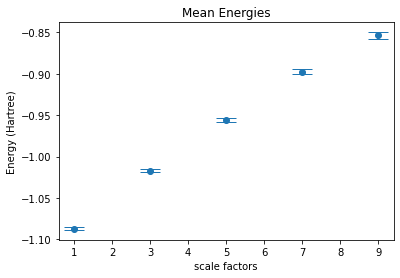

In [65]:
#Plotting the results 
vqe_mean = means
vqe_std = std_devs
vqe_err  = errs_on_mean

#Plotting means 
plt.figure()
plt.errorbar(scales, vqe_mean, yerr=vqe_err,capsize = 10, fmt ='o' )

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.show()

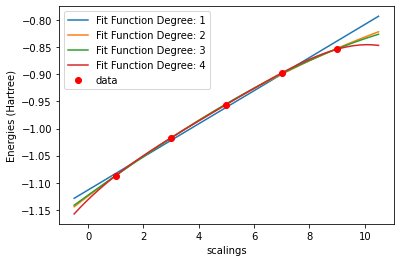

In [66]:
#Polynomial Curve Fitting (4th order)
import matplotlib.pyplot as plt
import numpy as np

funcs = []
n_degree = 4
for i in range(1,n_degree+1): 
    param= np.polyfit(scales, vqe_mean, i, w=[1/j for j in vqe_std])
    p = np.poly1d(param)
    funcs.append(p)
    
#Plotting 
x = np.linspace(-0.5, 10.5, 50)
for p in funcs: 
    plt.plot(x, p(x), label='Fit Function Degree: ' + str(p.order))
plt.plot(scales, vqe_mean, 'ro',label='data')
plt.xlabel('scalings')
plt.ylabel('Energies (Hartree)')
plt.legend()
plt.show()

# Zero Error Extrapolation

In [172]:
def RichardsonExtrap_Odd(energies): 
    """
    Input: An array of energies scaled with different stretch factors--normal integer multiples only --eg 1,2,3,4..
    Assumption: Odd scalings - 1,3,5,7,...
    Output: Zero Error extrapolated answer
    """
    n = len(energies)
    scales = [2*i+1 for i in range(n)]
    
    #setting up all equations 
    equations = []
    for eq_num in scales: 
        equation = []
        if eq_num == 1: 
            for i in range(n): 
                equation.append(1)
            equations = [equation]
        else: 
            for term_num in scales: 
                term = term_num**(int(eq_num/2))
                equation.append(term)
            equations = np.append(equations, [equation], axis = 0)
    #print(equations)
    
    #Now filling up equals to matrix 
    equals_to = [1]
    for i in range(1, n): 
        equals_to.append(0)
    #print(equals_to)
    
    #solving the system
    coeff = np.linalg.solve(equations, equals_to)
    #print(coeff)
    
    #Combine coeff with energies to get zero noise result 
    result = np.dot(coeff, energies)
    return result

## Monte Carlo Zero Errors

***Modified to work in scales = 1,3,5,7.. case***

In [173]:
def MonteCarloError(means, std_devs, poly_fit = False, deg = 1, sampling_size = 1000): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, whether to do richardson i.e. no poly fit 
    If doing polyfit, then specify degree, sampling_size is how many times to sample from the Gaussian 
    
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    zero_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        ##Doing either richardson or funcs 
        ###Polynomial
        if poly_fit: 
            ####need the scale values: 
            scales = []
            scales = [2*c +1 for c in range(n)]
            ####making the function 
            param = np.polyfit(scales, energies, deg, w = [1/i for i in std_devs])
            f = np.poly1d(param)
            ####extrapolation
            result = f(0)
            zero_noise_energies.append(result)
            
        ###Richardson
        else: 
            result = RichardsonExtrap_Odd(energies)
            zero_noise_energies.append(result)
    
    #Returning error i.e. std 
    error = np.std(zero_noise_energies)
    return error
    
        

## Computing the Zero Uncertainities

In [174]:
#Richardson Extrap Error(Uncertainity)
R_uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = False)

#Polynomial Fits Errors (Uncertainities)
poly_uncerts = []
for i in range(1, n_degree+1): 
    uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = True, deg = i)
    poly_uncerts.append(uncert)

In [175]:
R_uncert

0.05431631070061794

In [176]:
poly_uncerts

[0.008641106052966073,
 0.013227966539751487,
 0.022957620319655075,
 0.05310320474759058]

## Evaluating Zero Noise Results

In [177]:
#Richardson 
R_zero = RichardsonExtrap_Odd(vqe_mean)

##Finding zero_noise
poly_zero = []
for f in funcs:
    poly_zero.append(f(0))

In [178]:
funcs

[poly1d([ 0.03053245, -1.11342925]),
 poly1d([-9.32509850e-04,  3.86766249e-02, -1.12479310e+00]),
 poly1d([-3.93014945e-05, -3.78964056e-04,  3.65936901e-02, -1.12303591e+00]),
 poly1d([-4.35417218e-05,  8.07275579e-04, -5.79281843e-03,  4.93346203e-02,
        -1.13127524e+00])]

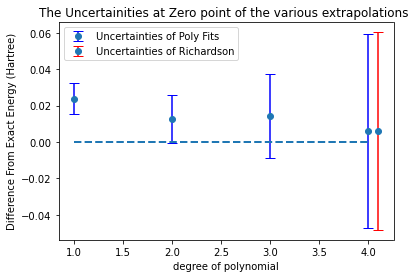

In [179]:
import matplotlib.pyplot as plt 
degrees = []
for i in range(n_degree): 
    degrees.append(i+1)
plt.errorbar(degrees, [energy - exact_energy[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.errorbar(n_degree+.1, R_zero- exact_energy[0], yerr=R_uncert, capsize = 5,fmt ='o', ecolor = 'red' , label = 'Uncertainties of Richardson')
plt.plot()
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.plot(degrees, [0*i for i in range(len(degrees))], linestyle = '--', linewidth = 2)
plt.legend()
plt.show()

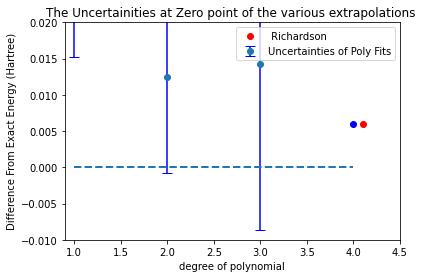

In [180]:
plt.errorbar(degrees[:-1], [energy - exact_energy[0] for energy in poly_zero[:-1]], yerr=poly_uncerts[:-1], capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.plot(n_degree, poly_zero[n_degree-1] - exact_energy[0], 'bo')
plt.plot(n_degree+.1, R_zero- exact_energy[0], 'ro' , label = ' Richardson')
plt.axis([0.9,n_degree +0.5,-0.01, 0.02])
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.plot(degrees, [0*i for i in range(len(degrees))], linestyle = '--', linewidth = 2)
plt.legend()
plt.show()

# Zero Noise Extrapolation across various Orders

### Monte Carlo Function (For arbitrary point)
***Modified to work in scales = 1,3,5,7.. case***

In [185]:
def MonteCarloErrorAtArbitPoint(means, std_devs, deg = 1, sampling_size = 1000, x=0): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, degree of fit, 
            sampling_size is how many times to sample from the Gaussian ,x is point at which to 
            approx error
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    x_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        
    ##Polynomial
        ####need the scale values: 
        scales = []
        scales = [2*c +1 for c in range(n) ]
        ####making the function 
        param = np.polyfit(scales, energies, deg, w = [1/i for i in std_devs])
        f = np.poly1d(param)
        ####extrapolation
        result = f(x)
        x_noise_energies.append(result)
            
    
    #Returning error i.e. std 
    error = np.std(x_noise_energies)
    return error

In [186]:
def UncertAtZeroAcrossOrder(order): 
    """
    Input: Order (int)
    Return: Plot of uncert of Richie and polys at zero using (order+1 ) energies
    """
    fig = plt.figure(figsize = [10,10])
    num_funcs = order
    energies = vqe_mean[: order+1]
    std_dev = vqe_std[: order+1]
    scales = [2*num + 1 for num in range(order+1)]
    func_deg = [i+1 for i in range(num_funcs)]
    
    #Energy At Zero 
    
    ##Richardson 
    R_energy = RichardsonExtrap_Odd(energies)
    
    ##Polynomials
    funcys = []
    covys = []
    func_en =[]
    for i in range(num_funcs): 
        degree = i+1
        param= np.polyfit(scales, energies, degree)
        f = np.poly1d(param)
        funcys.append(f)
        covys.append(cov)
        func_en.append(f(0))
    
    #Uncertainties at Zero 
    
    ##Richardson 
    R_uncert = MonteCarloError(energies, std_dev, poly_fit = False)
    
    ##Polynomials 
    func_uncert = []
    for i in range(num_funcs): 
        uncert =  MonteCarloErrorAtArbitPoint(energies, std_dev, deg = i+1, sampling_size = 1000, x=0)
        func_uncert.append(uncert)
    
    exact_energies = exact_energy
    #Plotting 
    #plt.yticks(np.arange(-1, 1, 0.01), figure = fig)
    ##Richardson 
    plt.errorbar(order+0.1, R_zero- exact_energies[0], yerr=R_uncert, capsize = 5,fmt =' ', ecolor = 'red' , label = 'Uncertainties of Richardson', figure = fig)
    plt.plot(order+0.1, R_zero- exact_energies[0],  'ro', figure = fig)
    
    ##Polynomials 
    plt.errorbar(func_deg, [energy - exact_energies[0] for energy in func_en], yerr=func_uncert, capsize = 5,fmt =' ', ecolor = 'blue', label = 'Uncertainties of Poly Fits', figure = fig)
    plt.plot(func_deg, [energy - exact_energies[0] for energy in func_en], 'bo', figure = fig)
    #Horizontal Line to check accuracy 
    plt.plot(func_deg, [0*i for i in range(len(func_deg))], linestyle = '--', linewidth = 2)
    diff = [energy - exact_energies[0] for energy in func_en] + R_zero- exact_energies[0]
    plt.yticks(np.arange(min(diff), max(diff)+0.1, 0.01))
    plt.xlabel('degree of polynomial', figure = fig)
    plt.ylabel('Difference From Exact Energy (Hartree)', figure = fig)
    plt.legend()
    plt.title('Order '+ str(order)+': The Uncertainities at Zero point of the various extrapolations ', figure = fig)
    
    return fig

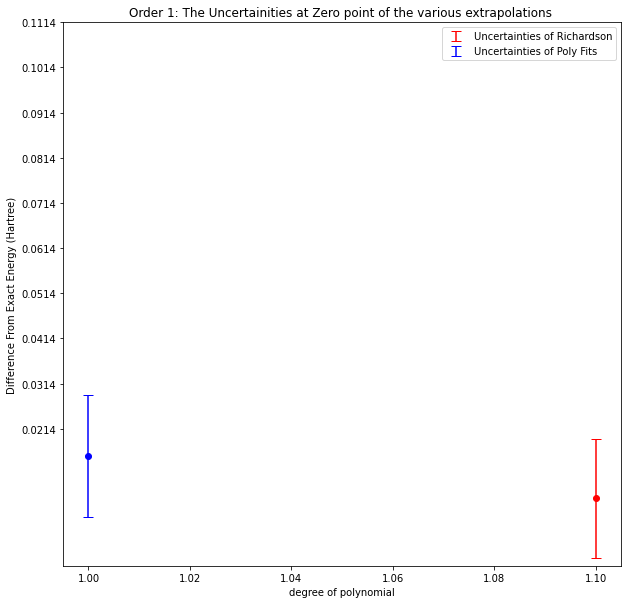

In [187]:
# First Order 
plot = UncertAtZeroAcrossOrder(1)
plot.show()

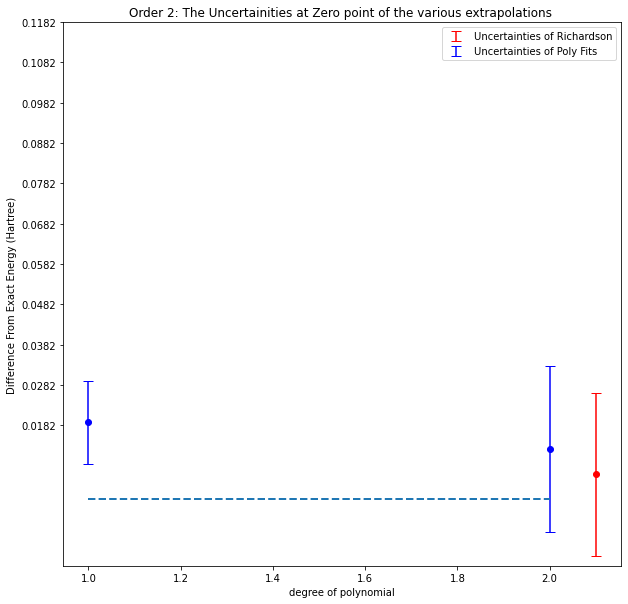

In [188]:
# Second Order 
plot = UncertAtZeroAcrossOrder(2)
plot.show()

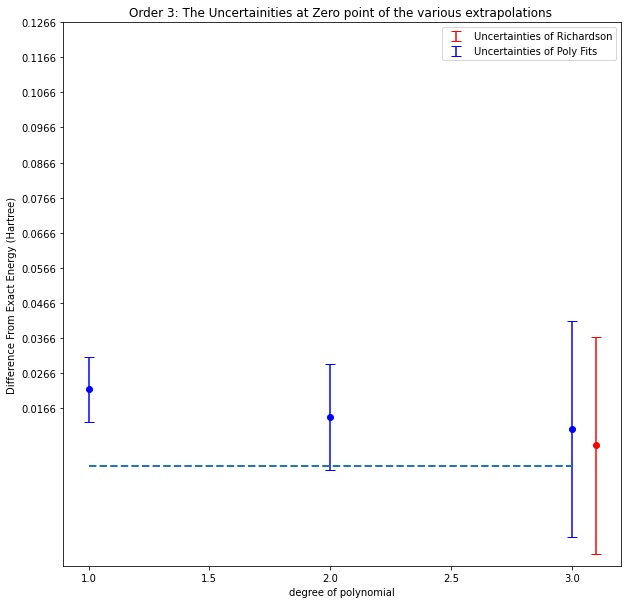

In [189]:
# Third Order 
plot = UncertAtZeroAcrossOrder(3)
plot.show()

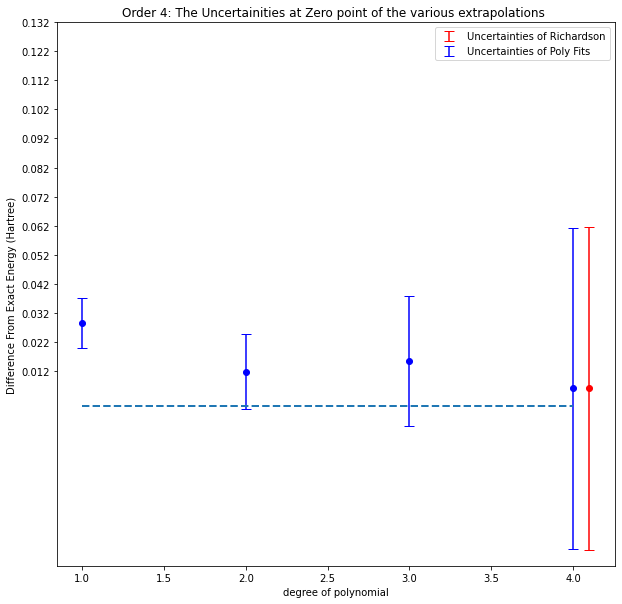

In [190]:
# Fourth Order 
plot = UncertAtZeroAcrossOrder(4)
plot.show()

# Chi Square and F stats

In [193]:
#Monte Carlo 

monte_uncerts = []
for i in range(1, n_degree+1): 
    poly_uncerts = []
    for j in range(len(scales)):
        uncert = MonteCarloErrorAtArbitPoint(vqe_mean, vqe_std, deg = i, sampling_size = 1000, x=j)
        poly_uncerts.append(uncert)
    monte_uncerts.append(poly_uncerts)

In [194]:
def chisq_(deg): 
    obs = funcs[deg-1](scales)
    exp = vqe_mean
    data_err = vqe_err
    fit_err = monte_uncerts[deg-1]
    chisq=0
    for i in range(len(scales)): 
        chisq+=((obs[i] - exp[i])**2)/((data_err[i])**2 + (fit_err[i])**2)
    return chisq
for i in range(1, n_degree+1):
    print("Chi Square Statistics for polynomial fit of degree " +str(i)+  ":" )
    ddof = n_degree-i
    print(str(chisq_(i)/ddof))

Chi Square Statistics for polynomial fit of degree 1:
2.3722405132921898
Chi Square Statistics for polynomial fit of degree 2:
0.07771348466663099
Chi Square Statistics for polynomial fit of degree 3:
0.06120687949384391
Chi Square Statistics for polynomial fit of degree 4:
inf


In [197]:
import scipy

num_scales = len(scales)
# F-statistic calculator without zero error energy: 
def F_stat(deg_one, deg_two):
    num =( chisq_(deg_one) - chisq_(deg_two))/(deg_two -deg_one )
    denum= (chisq_(deg_two))/(num_scales - (deg_two+1))
    return num/denum
def F_checker(f_stat, df_1, df_2):
    alpha = 0.05
    p_val = 1-scipy.stats.f.cdf(f_stat, df_1, df_2)
    print('p val is ' + str(p_val))
    if (p_val< alpha):
        print('Higher degree is better!')
    else: 
        print('Lower degree is better!')
#calculating f stats of adjacent degrees
f_stats = []

for i in degrees[:-1]:
    f = F_stat(i,i+1)
    print('F stat for degree ' + str(i) +' vs '+ str(i+1) + ': ' + str(f))
    F_checker(f, i, i+1)
    
    f_stats.append(f)

F stat for degree 1 vs 2: 89.57640492387267
p val is 0.010980124962225002
Higher degree is better!
F stat for degree 2 vs 3: 1.5393709108940046
p val is 0.34670598175572664
Lower degree is better!
F stat for degree 3 vs 4: 0.0
p val is 1.0
Lower degree is better!
